In [10]:
import pandas as pd
import numpy as np
import xgboost as xg
import seaborn as sns
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import joblib

In [2]:
#import data
data = pd.read_csv(r'Debernardi et al 2020 data.csv')

In [3]:
#inspect the data
data.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [4]:
#create a copy of the data to work on
X = data.copy()

In [5]:
#begin transforming the data, to prevent contamination
X = X.drop(['sample_id', 'patient_cohort', 'sample_origin', 'stage', 'benign_sample_diagnosis'], axis = 1)
X['sex'] = X['sex'].map({'M':1, 'F':0})
X['diagnosis'] = X['diagnosis'].map({1:0, 2:0, 3:1})
y = X.pop('diagnosis')

In [6]:
#splitting the data for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8)
#further splitting the validation data for further testing
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, train_size = 0.5)

In [7]:
#defining the search space for hyperparameter optimisation
space = {
        'n_estimators': hp.choice('n_estimators', np.arange(100, 1000, dtype=int)),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'objective': 'binary:logistic',
        'eval_metric': 'rmse'
}

def hyperparameter_optimization(space):
    model = XGBClassifier(**space, early_stopping_rounds=25)
    model.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],verbose=False)
    pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, pred)
    #print('Score:', accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

trials = Trials()
best_params = fmin(fn=hyperparameter_optimization,
            space=space,
            algo=tpe.suggest,
            max_evals=250,
            trials=trials)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:45<00:00,  5.51trial/s, best loss: -0.9152542372881356]


In [8]:
optimized_model = XGBClassifier(**best_params, early_stopping_rounds = 25)
optimized_model.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],verbose=False)
independent_eval_pred = optimized_model.predict(X_test)
accuracy_eval = accuracy_score(independent_eval_pred, y_test)
print('Accuracy on test data: ', + accuracy_eval)

Accuracy on test data:  0.9322033898305084


<AxesSubplot:>

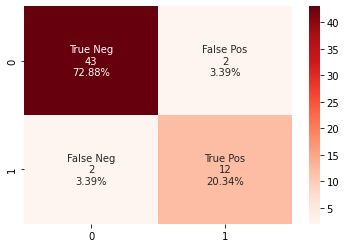

In [9]:
cf_matrix = confusion_matrix(y_test, independent_eval_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')